# Systemic economic impacts of a transportation corridor failure

This notebook presents an example to demonstarte the systemic economic effects of a transportation corridor (road) failure in Belgium. We will follow the steps outlined below:

1. **Data preparation:**  
   We will first download and create a network graph of the road network of Belgium. Next, we idealise the network into 11 nodes (corresponding to 11-NUTS-2 regions of Belgium) and 20 corridors b/w them.

2. **Baseline distance b/w the regions:**  
   We estimate the distances between the nodes using shortest-path under a no disruption scenario.

3. **Distance b/w the regions under disruption:**  
   For this example, we assume the road between Limburg-BE (BE-22) and Liege (BE-33) is disrupted. Now we estimate the additional distances travelled b/w regions because of the disrupted corridor. 

5. **Input-Output Table aggregation:**  
   Next, we read the input-output table for belgium and aggregate land-transportation sector into a value-added category. Also, we perform a basic input-output check.

6. **System-level economic effects:**  
   We use a cost-push IO model (price model) to estimate the increased prices of goods which further leads to decreased consumption. Then, we employ a conventional leontief I-O (quantity model) to estimate the reduced production (output) across regions.
   
7. **Results visualisation:**  
   Finally, we visualise the regional production losses across different NUTS-2 regions of Belgium


## 1. Loading the required Packages and path directories

In [1]:
# HIDE CODE
import geopandas as gpd
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import damagescanner.download as download
import osmnx as ox
import networkx as nx
from shapely.ops import unary_union, linemerge
from shapely.geometry import Point


import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns
import matplotlib as mpl

from pathlib import Path
import os
import pyarrow
import openpyxl
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS")

C:\Users\sva100\AppData\Local\miniforge3\envs\mria\Lib\site-packages\xarray\backends\scipy_.py:39: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.io import netcdf_file as netcdf_file_base


In [2]:
base_path = Path(os.path.dirname(os.getcwd()) + "/data")
outpath = Path(os.path.dirname(os.getcwd()) + "/output")

## 2. Loading the Data


For the development of this notebook, we consider Belgium as the country of interest and roads for the Critical Infrastructure

In [3]:
# NUTS 2016 Classification EU level
nuts_eu = gpd.read_file(base_path / 'NUTS_RG_03M_2016_4326.gpkg')

# NUTS-2 Regions of Belgium
nuts_be = nuts_eu[(nuts_eu['LEVL_CODE'] == 2) & (nuts_eu['CNTR_CODE'] == 'BE')].reset_index(drop = True)

### Visualising the NUTS-2 Belgium regions

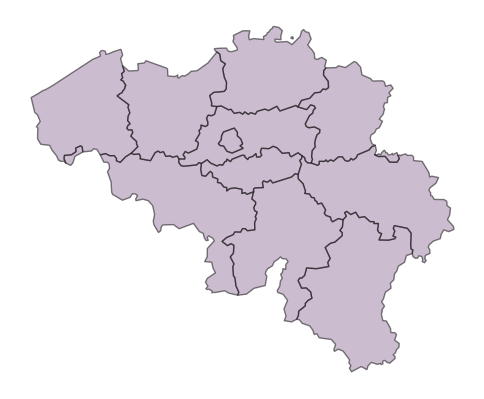

In [4]:
# Plotting
fig, ax = plt.subplots(figsize=(6,6))
nuts_be.plot(ax=ax, color = '#9A7AA0',  edgecolor='k', alpha = 0.5)
ax.axis('off')
plt.show()

### Creating a points dataframe

This will be usedful in the later part of the notebook, where the points are assumed as nodes of the network

In [5]:
# Point dataframe of NUTS-2 region of Netherlands
nuts_be_point = nuts_be.copy()
nuts_be_point['geometry'] = nuts_be.centroid

Downloading the roads of Belgium using damagescanner

In [6]:
# Downlaoding the openstreetmap data for the country of belgium
# The path contains the location of the downloaded pbf file
infrastructure_path = download.get_country_geofabrik('BEL') 

In [7]:
%%time

# Filtering the line types
roads = gpd.read_file(infrastructure_path, layer="lines")

# Filtering the dataframe such that the highway columns is not None
roads = roads[roads["highway"].values != None]

CPU times: total: 1min 21s
Wall time: 1min 10s


In [8]:
roads.head()

,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,z_order,other_tags,geometry
0,75146,Rue de Thiribut,residential,None,None,None,None,None,3,None,"LINESTRING (5.00314 50.57241, 5.0032 50.57244,..."
1,195145,None,motorway_link,None,None,None,None,None,9,"""destination""=>""Andenne;Bierwart;Mécalys;Ciney...","LINESTRING (5.06149 50.53069, 5.0604 50.53082,..."
2,195314,None,motorway_link,None,None,None,None,None,9,"""destination""=>""Hannut;Hingeon"",""destination:r...","LINESTRING (5.00917 50.53085, 5.01038 50.53093..."
3,197574,None,trunk,None,None,None,None,None,8,"""junction""=>""roundabout"",""lanes""=>""3"",""lit""=>""...","LINESTRING (4.52797 50.45663, 4.52794 50.45655..."
4,197576,Rue du Bois des Loges,residential,None,None,None,None,None,3,"""lanes""=>""2"",""lit""=>""yes"",""maxspeed""=>""30"",""su...","LINESTRING (4.96795 50.33742, 4.96782 50.33746..."


## 3. Build a network graph of the roads

In [9]:
def build_graph(roads):

    """
    Function to create a network graph i.e., a network of nodes and edges from a dataframe of roads
    ----------
    roads : geodataframe with lines as geometries
    
    Returns
    -------
    G : network-x graph
        A graph of nodes and edges. The edges are the linestrings in the roads geodataframe
    """

    roads = roads.copy()
    roads["length_m"] = roads.to_crs("EPSG:31370").geometry.length

    # Creating osmid column
    if "osm_id" not in roads.columns:
        roads["osm_id"] = range(len(roads))
        
    # Initiate a network x graph
    G = nx.Graph()
    
    for _, row in tqdm(roads.iterrows(), total = len(roads), desc = 'Building road graph'):
        start = row.geometry.coords[0]
        end   = row.geometry.coords[-1]
        
        # Adding edge to the graph
        G.add_edge(start, end,osmid = row["osm_id"], length_m = row["length_m"], geometry = row.geometry)
        
    # Only using the largest connected component 
    largest = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest).copy()
    G.graph["crs"] = "EPSG:4326"
    
    return G

In [10]:
G = build_graph(roads)

Building road graph: 100%|███████████████████████████████████████████████████████| 1451857/1451857 [01:26<00:00, 16692.55it/s]


## 4. Plotting the road network of belgium

Nodes: 600064
Edges: 710151


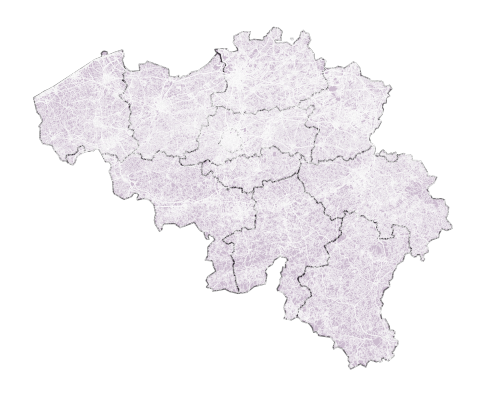

In [11]:
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

# Plotting

# Extracting edges and creating a geodataframe
edges = [(G[u][v]["geometry"]) for u, v in G.edges()]
edge_gdf = gpd.GeoDataFrame({"geometry": edges}, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(6, 6))
nuts_be.plot(ax=ax, color = '#9A7AA0',  edgecolor='k', zorder=1, alpha = 0.5)
edge_gdf.plot(ax=ax, color="white", linewidth=0.5, alpha = 0.5, zorder=2)
ax.axis('off')
plt.show()

Next, we create a stylised representation of the road network between NUTS-2 regions of Belgium

Adjaceny matrices are square matrices of size equal to the number of nodes. Here, we consider the NUTS-2 regions as nodes. They contain the connectivity information between the regions. adj(i,j) = 1 if i and j has an edge between them; else 0.

In [12]:
# Adjacenct matrix for the network
adj_df = pd.read_excel(base_path /'adj_matrix.xlsx', index_col = 0)

Plotting the stylised road network of Belgium

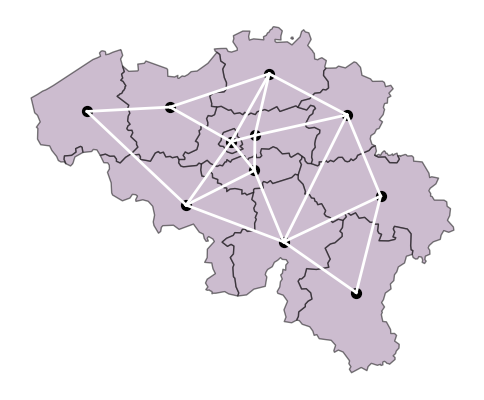

In [13]:
points = np.array([[pt.x, pt.y] for pt in nuts_be_point.geometry])
nuts_ids = nuts_be_point["NUTS_ID"].values

# Build a mapping from NUTS_ID to index
nuts_to_idx = {nid: i for i, nid in enumerate(nuts_ids)}

fig, ax = plt.subplots(figsize=(6,6))

# Plot the points
nuts_be.plot(ax=ax, color = '#9A7AA0',  edgecolor='k',  alpha = 0.5)
nuts_be_point.plot(ax=ax, color='k', markersize=50)

# Plot edges from adjacency DataFrame
for i, start in enumerate(adj_df.index):
    for j, end in enumerate(adj_df.columns):
        if adj_df.loc[start, end] == 1 and i < j:  # avoid double plotting
            x = [points[nuts_to_idx[start], 0], points[nuts_to_idx[end], 0]]
            y = [points[nuts_to_idx[start], 1], points[nuts_to_idx[end], 1]]
            ax.plot(x, y, color='white', lw=2)
            
ax.axis('off')
plt.show()

Now, we replace the straight lines with actual roads from the previously generated network graph

In [14]:
def nearest_node(G, lon, lat):
    """
    Function to identify the closest node in a graph to the coordinates of interest
    ----------
    G : network-x graph
    lon: longitude of the coordinate of interest
    lat: latitude of the coordinate of interest
    
    Returns
    -------
    The closest node to the coordinates of interest
    """
    
    nodes = list(G.nodes)
    nodes_arr = np.array(nodes)
    dists = np.hypot(nodes_arr[:, 0] - lon, nodes_arr[:, 1] - lat)
    return nodes[np.argmin(dists)]

In [15]:
# Using points dataframe to extract latitude and longitude
nuts_be_point['x'] = nuts_be_point.geometry.x
nuts_be_point['y'] = nuts_be_point.geometry.y

In [16]:
records = []


for i in range(len(nuts_be_point)):
    for j in range(len(nuts_be_point)):

        nutsid_1 = nuts_be_point.loc[i, 'NUTS_ID']
        nutsid_2 = nuts_be_point.loc[j, 'NUTS_ID']

        connection = adj_df.loc[nutsid_1, nutsid_2]

        if connection == 1:
            
            node_a = nearest_node(G, lon=nuts_be_point.loc[i,'x'],   lat=nuts_be_point.loc[i,'y'])
            node_b = nearest_node(G, lon=nuts_be_point.loc[j,'x'],   lat=nuts_be_point.loc[j,'y'])

            # Identifying the shorteest path
            path = nx.shortest_path(G, node_a, node_b, weight="length_m")

            # Converting multiple linestrings into a single line
            path_geoms = [G[u][v]["geometry"] for u, v in zip(path[:-1], path[1:])]
            single_line = linemerge(path_geoms)

            #  Appending to the list that stores the start, end and the adge information
            records.append({"nutsid_1": nutsid_1, "nutsid_2": nutsid_2, "geometry": single_line})

In [17]:
# Converting the edges to the dataframe
roads_nuts2 = gpd.GeoDataFrame(records, geometry="geometry", crs=nuts_be_point.crs)

Creating a new graph with only NUTS-2 regions as nodes and the actual shortest path b/w them as edges

In [18]:
G_nuts = build_graph(roads_nuts2)

Building road graph: 100%|██████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 6830.00it/s]


Visualising the stylised network with actual roads

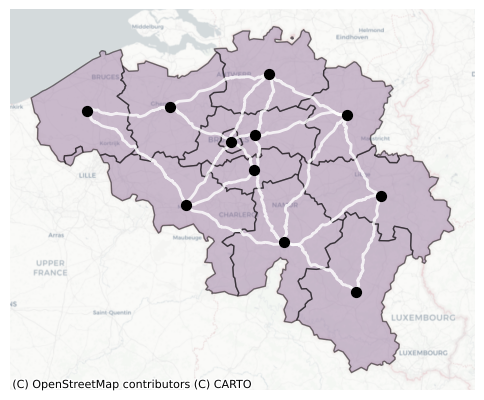

In [19]:
fig, ax = plt.subplots(figsize=(6,6))

# NUTS-2 polygons
nuts_be.plot(ax=ax, color = '#9A7AA0',  edgecolor='k', zorder = 1, alpha = 0.5)\

# NUTS-2 points
nuts_be_point.plot(ax=ax, color='k', markersize=50, zorder = 3)

# Roads
edges_nuts = [(G_nuts[u][v]["geometry"]) for u, v in G_nuts.edges()]
edge_gdf_nuts = gpd.GeoDataFrame({"geometry": edges_nuts}, crs="EPSG:4326")
edge_gdf_nuts.plot(ax=ax, color="white", linewidth=2, alpha = 0.8, linestyle="-", zorder = 2)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=nuts_be.crs)

ax.axis('off')
plt.show()

## 5. Baseline distance between the regions

In [20]:
# An empty dataframe of size regions x regions to store the distance b/w them
distance_base = pd.DataFrame(index = nuts_ids, columns = nuts_ids)

In [21]:
for i in range(len(nuts_be_point)):
    for j in range(len(nuts_be_point)):

        # NUTS-IDs
        nutsid_1 = nuts_be_point.loc[i, 'NUTS_ID']
        nutsid_2 = nuts_be_point.loc[j, 'NUTS_ID']

        # Identifying the closest points in the graph
        node_a = nearest_node(G_nuts, lon=nuts_be_point.loc[i,'x'],   lat=nuts_be_point.loc[i,'y'])
        node_b = nearest_node(G_nuts, lon=nuts_be_point.loc[j,'x'],   lat=nuts_be_point.loc[j,'y'])

        # Distance in km
        dist_km = nx.shortest_path_length(G_nuts, node_a, node_b, weight="length_m")/1000
        distance_base.loc[nutsid_1, nutsid_2] = dist_km
        

### Plotting a heatmap of distances b/w the regions

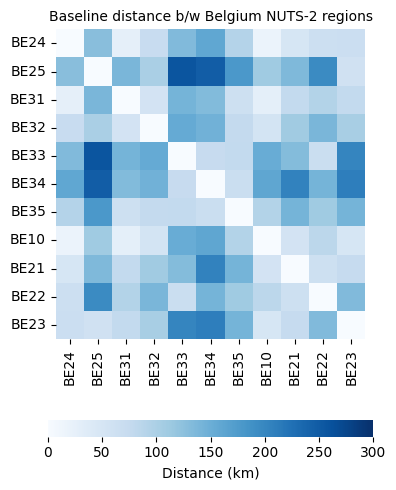

In [22]:
plt.figure(figsize=(5, 5))

distance_base = distance_base.astype(float)

ax = sns.heatmap(
    distance_base,
    cmap="Blues",
    vmin=0,
    vmax=300,
    square=True,
    cbar_kws={"label": "Distance (km)", "orientation": "horizontal","pad": 0.2,"fraction": 0.04})

ax.set_title("Baseline distance b/w Belgium NUTS-2 regions", fontsize = 10)

plt.tight_layout()
plt.show()

## 6. Distance between the regions under disruption

In [23]:
# The NUTS-2 IDs representing the start and end node of the failed corridor
province1 = 'BE22'
province2 = 'BE33'

In [24]:
def edge_removed_graph(G_fn, province1, province2):
    """
    Function to create a new network graph by removing the edge b/w two NUTS-2 regions
    ----------
    G_fn : network-x graph with all roads
    province1: The NUTS-2 IDs representing the start node of the failed corridor
    province2: The NUTS-2 IDs representing the end node of the failed corridor
    
    Returns
    -------
    an updated network graph with the edge b/w the nodes of interest removed
    """

    G_new = G_fn.copy()
    
    # The nearest nodes in the network
    node_a = nearest_node(G_new, lon=nuts_be_point[nuts_be_point['NUTS_ID'] == province1].reset_index(drop = True).loc[0,'x'],   lat=nuts_be_point[nuts_be_point['NUTS_ID'] == province1].reset_index(drop = True).loc[0,'y'])
    node_b = nearest_node(G_new, lon=nuts_be_point[nuts_be_point['NUTS_ID'] == province2].reset_index(drop = True).loc[0,'x'],   lat=nuts_be_point[nuts_be_point['NUTS_ID'] == province2].reset_index(drop = True).loc[0,'y'])

    # Remove the edge
    G_new.remove_edge(node_a, node_b)
    
    return G_new

In [25]:
# Revised graph with failed edge removed
G_nuts_disrupt = edge_removed_graph(G_nuts, province1, province2)

### Visualising the failed corridor

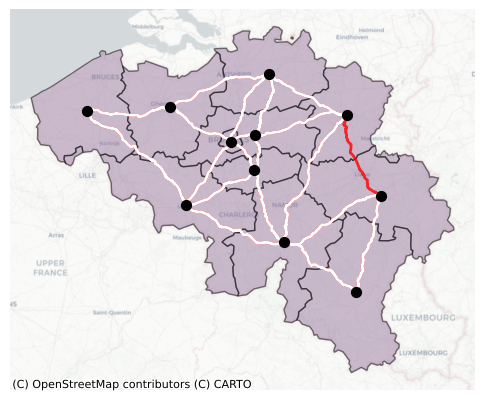

In [26]:
fig, ax = plt.subplots(figsize=(6,6))

# Plot the points

nuts_be.plot(ax=ax, color = '#9A7AA0',  edgecolor='k', zorder = 1, alpha = 0.5)
nuts_be_point.plot(ax=ax, color='k', markersize=50, zorder = 4)

# plot it
edges_nuts = [(G_nuts[u][v]["geometry"]) for u, v in G_nuts.edges()]
edge_gdf_nuts = gpd.GeoDataFrame({"geometry": edges_nuts}, crs="EPSG:4326")
edge_gdf_nuts.plot(ax=ax, color="r", linewidth=2, alpha = 0.8, linestyle="-", zorder = 2)

edges_nuts_d = [(G_nuts_disrupt[u][v]["geometry"]) for u, v in G_nuts_disrupt.edges()]
edge_gdf_nuts_d = gpd.GeoDataFrame({"geometry": edges_nuts_d}, crs="EPSG:4326")
edge_gdf_nuts_d.plot(ax=ax, color="white", linewidth=2, alpha = 1, linestyle="-", zorder = 3)


cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=nuts_be.crs)

ax.axis('off')
plt.show()

Since a corrdior is removed, the shortest distance b/w some of the regions might increase. Next, we estimate the increased distances b/w the regions.

In [27]:
# An empty dataframe to hold the distance b/w regions after disruption
distance_disrupt = pd.DataFrame(index = nuts_ids, columns = nuts_ids)

for i in range(len(nuts_be_point)):
    for j in range(len(nuts_be_point)):

        # NUTS-ID
        nutsid_1 = nuts_be_point.loc[i, 'NUTS_ID']
        nutsid_2 = nuts_be_point.loc[j, 'NUTS_ID']

        # Nearest nodes in the network graph
        node_a = nearest_node(G_nuts_disrupt, lon=nuts_be_point.loc[i,'x'],   lat=nuts_be_point.loc[i,'y'])
        node_b = nearest_node(G_nuts_disrupt, lon=nuts_be_point.loc[j,'x'],   lat=nuts_be_point.loc[j,'y'])

        # Distance in km
        dist_km = nx.shortest_path_length(G_nuts_disrupt, node_a, node_b, weight="length_m")/1000
        distance_disrupt.loc[nutsid_1, nutsid_2] = dist_km

In [28]:
# Increased distance between regions
delta_distance = distance_disrupt - distance_base

### Plotting a heatmap of increased distance between the regions

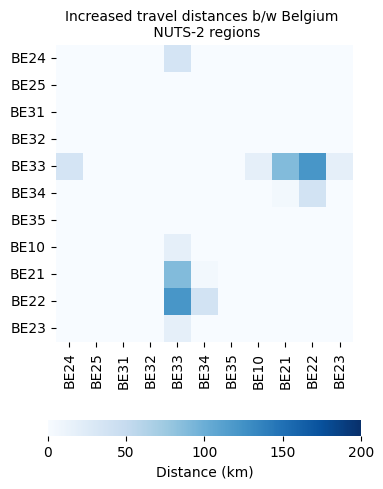

In [29]:
plt.figure(figsize=(5, 5))

delta_distance = delta_distance.astype(float)

ax = sns.heatmap(
    delta_distance,
    cmap="Blues",
    vmin=0,
    vmax=200,
    square=True,
    cbar_kws={"label": "Distance (km)", "orientation": "horizontal","pad": 0.2,"fraction": 0.04})

ax.set_title("Increased travel distances b/w Belgium \n NUTS-2 regions", fontsize = 10)

plt.tight_layout()
plt.show()

## 7. Input-Output table aggregation

The IO table above is an aggregated IO table for the NUTS-2 regions of Belgium
The sector 'p' represents products i.e., primarily sectors that produces physical goods e.g., agricultural , manufacturing, minining
The sector 's' represent service based sectors
The sector 't' represents the sector of land-transportation (H49 per NACE-2)

In [30]:
# Reading the IO table for Belgium
io = pd.read_excel(base_path / 'io_belgium.xlsx', index_col = [0,1], header = [0,1])

We aggregate all transporation sectors into one single row (value added by land-trasnport) and single column (final demand for land-trasnport sector)

In [31]:
# Transport value-added
tva = io.loc[( nuts_ids,'t'),:].sum(axis = 0)

# Dropping all 't' sector rows
io = io.drop(index ='t', level=1)

# Adding the value-added transport column again
io.loc[('R','VA_t'), :] = tva

# Transport final demands
tfd = io.loc[:,( nuts_ids,'t')].sum(axis = 1)

# Dropping all 't' sector columns
io = io.drop(columns ='t', level=1)

# Adding the value-added transport column again
io.loc[:, ('R','FD_t')] = tfd

IO check - Sum of rows (Output) equals sum of columns (Outlays)

In [32]:
io_check = pd.DataFrame(columns = ['rowsum', 'colsum'])

io_check['rowsum'] = io.sum(axis = 0)
io_check['colsum'] = io.sum(axis = 1)

io_check['diff'] = io_check['rowsum'] - io_check['colsum']


In [33]:
# Converting annaul IO flows to daily flows
io_daily = io/365

## 8. System-level economic effects


The increased travel distance between the origin and desinations primarily propagates into the economy via (a) Shortage effect - Products not available in time for continued production activities and (b) Price effect - The price of goods increases due to increased distances for tranporting goods from one region to other.

For this example, the delays caused by the corridor failure is in hours, primarily because of smaller geography and more re-reouting options available. Hence, we donot consider the shortage effects. However, shortage effects can be crucial when regions are inaccessible or delays are signifcantly large as in case of Suez canal blockage.





In [34]:
io.head()

r             BE10                        BE21                       BE22  \
sd               p             s             p             s            p   
BE10 p   52.797997    169.068634    130.508057     92.403465    60.889435   
     s  810.859680  26420.080078   2388.069580   6036.488770   309.333832   
BE21 p  762.007507   1893.024658  12033.195312   3364.795166  1763.075195   
     s  477.225769   4812.578125   9982.744141  18079.138672   574.655457   
BE22 p   79.502617    211.340836    450.302429    304.396393   264.505524   

r                           BE23                      BE24               ...  \
sd                s            p            s            p            s  ...   
BE10 p    43.626633   114.656288    68.264587    41.833893    73.736481  ...   
     s  1215.953979   602.770935  2433.725098   175.310715  2581.921387  ...   
BE21 p   811.292114  3706.054443  1643.714111  1364.426636  1704.064941  ...   
     s  1236.322388   929.046265  1922.102295   177.873260  1763.003174  ...   
BE22 p   238.780060   394.414520   264.914520   181.066040   175.944626  ...   

r              BE32         BE33                     BE34              \
sd                s            p            s           p           s   
BE10 p    55.379299    62.748283    55.710030   15.259095   11.886464   
     s  2333.582031   684.252686  2161.123779   82.515457  324.608032   
BE21 p   761.455383  1583.401855   895.615173  132.257812   76.832603   
     s  1423.620117   352.594543  1417.108643   37.778591  226.722488   
BE22 p   175.418854   256.165588   185.833847   32.977226   22.460728   

r             BE35                         R                             
sd               p           s            FD           exp         FD_t  
BE10 p   17.164982   24.522854   3790.647461   3332.961182    62.699004  
     s  103.369423  697.338135  52434.562500  15736.668945  1696.505419  
BE21 p  138.379105  157.111465  28321.802734  17103.281250  1462.361204  
     s   51.961910  533.839539  51692.222656   4190.382812  2383.296903  
BE22 p   45.922188   46.857548   5869.531738   6200.022949    59.759147  

[5 rows x 25 columns]

Preparing arrays for Input-Ouput analysis

In [35]:
# Intermediate consumption
Z = io_daily.loc[io.index.get_level_values(0) != 'R', io.columns.get_level_values(0) != 'R']

# Final consumption
fd = (io_daily.loc[io.index.get_level_values(0) != 'R', io.columns.get_level_values(0) == 'R'].sum(axis = 1).to_frame(name = 'FD'))

# Output = Intermediate consumption + Final consumption
x = (Z.sum(axis=1) + fd.sum(axis=1)).to_frame(name = 'x')

# Technical coefficients
A = pd.DataFrame(0, index = Z.index, columns = Z.columns, dtype = 'float64')

# Calculating technical coefficients
for i in range(len(x)):
    A.iloc[:,i] = Z.iloc[:,i] / x.iloc[i,0]

# Flattening final demand and Ouptu arrays
fd_array =fd.values.flatten()
x_array = x.values.flatten()

# Converting dataframe to numpy array
A_array = A.values

# Value added array
# This is vector equals the shape number of sectors (11 regions x 2 sectors) , number of va categories
# We have three VA categories VA, Imports and VA by land tranport

va = io_daily.loc[io.index.get_level_values(0) == 'R', io.columns.get_level_values(0) != 'R'].T.to_numpy()

# Dividing the va columns with output to determine va to output ratio for each category
va_x = va/x_array[:,None]

# Sum across the ratio to determine the total va to output ratio
va_x_sum = va_x.sum(axis =1)

Due to the increased travel distance between the NUTS-2 regions, the logistical costs of inputs increase. 
As a result, the price of outputs produced also increase. This can be quantified using Cost-Push IO model or the Leontief price model. 
Further, consumers reduce consumption due to higher prices. 
Reduced consumption also leads to reduced production upstream


Cost-push IO model is given by prices = (leontief inverse)' x (va/x). Refer Miller&Blair(2009), Chapter 2 for more details.

In [36]:
#Leontief inverse
leontief_inverse = np.linalg.inv(np.eye(len(x_array)) - A_array)

# Leontief inverse transpose
leontief_inv_trans =  np.transpose(leontief_inverse)

Calculating base prices i.e., unit vector check

In [37]:
# Base prices
base_price = leontief_inv_trans@ va_x_sum 
base_price

array([1.00000001, 1.00000003, 1.00000001, 1.00000001, 0.99999998,
       1.00000003, 0.99999995, 1.00000004, 0.99999997, 1.00000003,
       0.99999997, 0.99999998, 1.        , 1.00000003, 1.00000002,
       0.99999998, 1.        , 1.00000002, 1.00000003, 0.99999996,
       1.00000001, 0.99999998])

We estimate the ratio of increased distance b/w pre and post disruption across nuts-2 regions.  1 indicates the flow is unaffected by the dirsuption.
Next, we calculate the flow weighted increase of this multiplier only for the product sectors. This multipler is then used to increase the value added cost and the new prices are estimated.

In [38]:
# Ratio of distance travelled in the disrupted scenario to the disatnce travelled in the baseline scenario
ratio_dist_disrupt = distance_disrupt.replace(0,1) / distance_base.replace(0,1)

# product flows
p_flow = io_daily.loc[io.index.get_level_values(1) == 'p', io.columns.get_level_values(1) == 'p']

p_flow.index = p_flow.index.droplevel(1)
p_flow.columns = p_flow.columns.droplevel(1)

#### Weighted ratios
ratio_p_weighted = ratio_dist_disrupt*p_flow

#### Divide the flows
va_t_multiplier = (ratio_p_weighted.sum() / p_flow.sum()).to_numpy()

We assume price shocks affect product sectors and not service secotrs. Service economic flows have less dependence on physical tranport networks compared to products.

Now, we estimate the increased prices

In [39]:
# Initialsiing a zero array to the length of all sectors
price_shock = np.ones(len(va_t_multiplier)*2)

# Price shocks only to the product sector
price_shock[::2] = va_t_multiplier

# Price shock is multiplied to the third column of value added which is the cost w.r.t to transport
va_x_revised = va_x.copy()
va_x_revised[:,2] *= price_shock

# Revised va_x_sum
va_x_sum_revised = va_x_revised.sum(axis =1)

# Increased prices
increased_price = leontief_inv_trans@ va_x_sum_revised
increased_price

array([1.00032725, 1.00006146, 1.00059645, 1.00008757, 1.00367501,
       1.00011536, 1.00040745, 1.00008718, 1.00040482, 1.00006862,
       1.00029563, 1.00009899, 1.000152  , 1.0000796 , 1.00031723,
       1.00009421, 1.00967718, 1.00012152, 1.00101725, 1.00008446,
       1.00027853, 1.00009101])



The increased prices are translated to corresponding reduction in consumption.  We assume that the demand curve follows dP/dQ = -1  i.e., dP increase in price will lead to dQ decrease in quantity. FD_price_effect = (FD_BASE x -dP)+FD_BASE



In [40]:
# final demands corrected for price effect
fd_price = (fd_array*(increased_price-1)*-1)+fd_array

Finally, we estimate the new production (or output) required for the reduced demand using a Leontief IO (quantity model)

In [41]:
# X = L-1 x fd
x_price = leontief_inverse@fd_price

# Reduction in output
del_x_price = x_array - x_price

# Creating a new column in the output dataframe
x['output_loss'] = del_x_price

# Aggregation regioanlly
x_groupued = x.groupby(level =0).sum()

# Merging it to the geodataframe
nuts_be_region = nuts_be.set_index('NUTS_ID')
nuts_price = gpd.GeoDataFrame(pd.merge(x_groupued, nuts_be_region , how = 'inner', left_index=True, right_index = True))

In [42]:
total_output_loss = nuts_price.output_loss.sum()

#### Results visualisation

Now, we plot the production decrease in each NUTS-2 region of Belgium. 

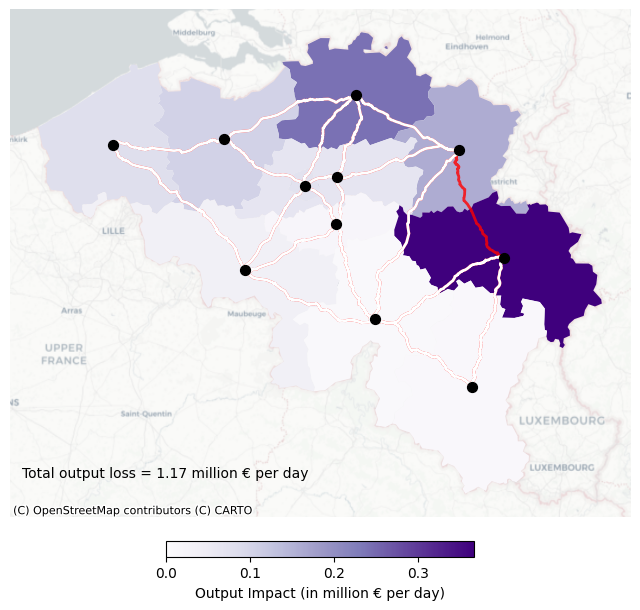

In [43]:
fig, ax = plt.subplots(figsize=(8,8))

# Plot the points
cmap = plt.cm.Purples
norm = mpl.colors.Normalize(vmin=0, vmax = nuts_price.output_loss.max())

# The nuts dataframe which also contains the information about output loss in the region
nuts_price.plot(ax = ax, column = 'output_loss', cmap = cmap, norm = norm)
nuts_be_point.plot(ax=ax, color='k', markersize=50, zorder = 4)

# Plotting the failed raod
edges_nuts = [(G_nuts[u][v]["geometry"]) for u, v in G_nuts.edges()]
edge_gdf_nuts = gpd.GeoDataFrame({"geometry": edges_nuts}, crs="EPSG:4326")
edge_gdf_nuts.plot(ax=ax, color="r", linewidth=2, alpha = 0.8, linestyle="-", zorder = 2)

# Plotting other roads
edges_nuts_d = [(G_nuts_disrupt[u][v]["geometry"]) for u, v in G_nuts_disrupt.edges()]
edge_gdf_nuts_d = gpd.GeoDataFrame({"geometry": edges_nuts_d}, crs="EPSG:4326")
edge_gdf_nuts_d.plot(ax=ax, color="white", linewidth=2, alpha = 1, linestyle="-", zorder = 3)

# A text box to indicate total loss
ax.text(0.02, 0.1, f'Total output loss = {total_output_loss:.2f} million € per day', transform=ax.transAxes, fontsize=10, verticalalignment='top',zorder=10)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=nuts_be.crs)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm,ax=ax,orientation='horizontal',fraction=0.025,   pad=0.04)
cbar.set_label('Output Impact (in million € per day)')

ax.axis('off')
plt.savefig(os.path.join(outpath, "systemic_impact.png"), dpi=300)
plt.show()